In [1]:
pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.0 MB/s eta 0:00:00


In [2]:
pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=583d83106df4ea0b4c75abfc6864585e49d77029a47f02d19b43234aef45b3b5
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
pip install sails

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 836.3 kB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.8.0
    Uninstalling importlib-metadata-6.8.0:
      Successfully uninstalled importlib-metadata-6.8.0


In [49]:
import emd.sift as sift
import emd.spectra as spectra
import numpy as np
import pingouin as pg
import sails
import scipy.io as sio
from scipy.stats import zscore
from scipy.signal import convolve2d
from scipy.stats import zscore, binned_statistic
import matplotlib.pyplot as plt

## Extracting data

In [9]:
lfp=sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/5/2021-07-06_15-49-34_posttrial5/HPC_100_CH14_0.continuous.mat')['HPC']
states=sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/5/2021-07-06_15-49-34_posttrial5/2021-07-06_15-49-34_posttrial5-states_ES.mat')['states']

In [12]:
print(lfp.shape)
print(states.shape)

(27004246, 1)
(1, 10801)


## Function definitions

In [13]:
import emd.sift as sift
import emd.spectra as spectra
import numpy as np
import pingouin as pg
import sails
from scipy.signal import convolve2d
from scipy.stats import zscore, binned_statistic
from scipy.ndimage import center_of_mass
from skimage.feature import peak_local_max


def get_rem_states(states, sample_rate):
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states


def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    return wavelet_transform


def tg_split(mask_freq, theta_range=(5, 12)):
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index

    return sub, theta, supra


def zero_cross(x):
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    zero_xs = np.sort(np.append(rise, decay))
    return zero_xs


def extrema(x):
    zero_xs = zero_cross(x)
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    return zero_xs, troughs, peaks


def get_cycles_data(x, rem_states, sample_rate, theta_range=(5, 12)):
    consecutive_rem_states = get_rem_states(rem_states, sample_rate)
    rem_imf = []
    rem_mask_freq = []
    instantaneous_phase = []
    instantaneous_freq = []
    instantaneous_amp = []
    sub_theta_sig = np.empty((0,))
    theta_peak_sig = np.empty((0,))
    cycles = np.empty((0, 5)).astype(int)
    rem_dict = {}
    sub_dict = rem_dict

    for i, rem in enumerate(consecutive_rem_states, start=1):
        sub_dict.setdefault(f'REM {i}', {})
        start = int(rem[0])
        end = int(rem[1])
        signal = x[start:end]
        imf, mask_freq = sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)
        IP, IF, IA = spectra.frequency_transform(imf, sample_rate, 'nht')
        sub_theta, theta, _ = tg_split(mask_freq, theta_range)

        rem_imf.append(imf)
        rem_mask_freq.append(mask_freq)
        instantaneous_phase.append(IP)
        instantaneous_freq.append(IF)
        instantaneous_amp.append(IA)

        theta_sig = np.sum(imf.T[theta], axis=0)
        sub_theta_sig = np.append(sub_theta_sig, np.sum(imf.T[sub_theta], axis=0))

        zero_x, trough, peak = extrema(np.sum(imf.T[theta], axis=0))

        zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

        size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
        zero_x = zero_x[:size_adjust]
        cycle = np.empty((size_adjust, 5)).astype(int)
        cycle[:, [0, 2, 4]] = zero_x
        if trough[0] < peak[0]:
            cycle[:, 1] = trough[:zero_x.shape[0]]
            cycle[:, 3] = peak[:zero_x.shape[0]]
        else:
            cycle[:, 3] = trough[:zero_x.shape[0]]
            cycle[:, 1] = peak[:zero_x.shape[0]]

        broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

        adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                         axis=0) == True)
        adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

        fixed_cycle = broken_cycle[1:-1]
        if adjust_condition:
            fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
            fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
        else:
            fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
            fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

        cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        cycle = np.vstack((cycle, fixed_cycle))
        if trough[0] < peak[0]:
            cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
        else:
            cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))

        theta_peak_sig = np.append(theta_peak_sig, theta_sig[cycle[:, 2]])
        cycles = np.vstack((cycles, cycle + start))

    min_peak_amp = 2 * sub_theta_sig.std()
    peak_mask = theta_peak_sig > min_peak_amp
    upper_diff = np.floor(1000 / np.min(theta_range))
    lower_diff = np.floor(1000 / np.max(theta_range))
    diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                               np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)

    extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)

    cycles = cycles[extrema_mask]

    for j, rem in enumerate(rem_dict.values()):
        rem['start-end'] = consecutive_rem_states[j]
        rem['IMFs'] = rem_imf[j]
        rem['IMF_Frequencies'] = rem_mask_freq[j]
        rem['Instantaneous Phases'] = instantaneous_phase[j]
        rem['Instantaneous Frequencies'] = instantaneous_freq[j]
        rem['Instantaneous Amplitudes'] = instantaneous_amp[j]
        cycles_mask = (cycles > consecutive_rem_states[j, 0]) & (cycles < consecutive_rem_states[j, 1])
        cycles_mask = np.all(cycles_mask == True, axis=1)
        rem_cycles = cycles[cycles_mask]
        rem['Cycles'] = rem_cycles
    return rem_dict


def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp


def calculate_cog(frequencies, angles, amplitudes, ratio):
    angles = np.deg2rad(angles)
    cog = np.empty((0, 2))
    if amplitudes.ndim == 2:
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=1))
        denominator = np.sum(amplitudes)
        cog_f = numerator / denominator
        floor = np.floor(cog_f).astype(int) - frequencies[0]
        ceil = np.ceil(cog_f).astype(int) - frequencies[0]
        new_fpp = np.where(amplitudes >= np.max(amplitudes[[floor, ceil], :]) * ratio, amplitudes, 0)
        cog_ph = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog = np.array([cog_f, cog_ph])
    elif amplitudes.ndim == 3:
        indices_to_subset = np.empty((amplitudes.shape[0], 2)).astype(int)
        cog = np.empty((amplitudes.shape[0], 2))
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=2), axis=1)
        denominator = np.sum(amplitudes, axis=(1, 2))
        cog_f = (numerator / denominator)
        vectorized_floor = np.vectorize(np.floor)
        vectorized_ceil = np.vectorize(np.ceil)
        indices_to_subset[:, 0] = vectorized_floor(cog_f) - frequencies[0]
        indices_to_subset[:, 1] = vectorized_ceil(cog_f) - frequencies[0]
        max_amps = np.max(amplitudes[np.arange(amplitudes.shape[0])[:, np.newaxis], indices_to_subset, :], axis=(1, 2))
        print(max_amps.shape)
        for i, max_amp in enumerate(max_amps):
            new_fpp = np.where(amplitudes[i] >= max_amp * ratio, amplitudes[i], 0)
            cog[i, 1] = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog[:, 0] = cog_f
    return cog


def boxcar_smooth(x, boxcar_window):
    if x.ndim == 1:
        if boxcar_window % 2 == 0:
            boxcar_window += 1
        window = np.ones((1, boxcar_window)) / boxcar_window
        x_spectrum = np.convolve(x, window, mode='same')
    else:
        bool_window = np.where(~boxcar_window % 2 == 0, boxcar_window, boxcar_window + 1)
        window_t = np.ones((1, bool_window[0])) / bool_window[0]
        window_f = np.ones((1, bool_window[1])) / bool_window[1]
        x_spectrum_t = convolve2d(x, window_t, mode='same')
        x_spectrum = convolve2d(x_spectrum_t, window_f.T, mode='same')

    return x_spectrum


# def peak_cog(frequencies, angles, amplitudes, ratio):
#     def nearest_peaks(frequency, angle, amplitude, ratio):
#         peak_indices = peak_local_max(amplitude, min_distance=1, threshold_abs=0)
#         cog_f = calculate_cog(frequency, angle, amplitude, ratio)

#         if peak_indices.shape[0] == 0:
#             cog_peak = cog_f
#         else:
#             cog_fx = np.array([cog_f[0], cog_f[0] * np.cos(np.deg2rad(cog_f[1] - angle[0])),
#                                cog_f[0] * np.sin(np.deg2rad(cog_f[1] - angle[0]))])
#             peak_loc = peak_loc = np.empty((peak_indices.shape[0], 4))
#             peak_loc[:, [0, 1]] = np.array([frequency[peak_indices.T[0]], angle[peak_indices.T[1]]]).T
#             peak_loc[:, 2] = peak_loc[:, 0] * np.cos(np.deg2rad(peak_loc[:, 1] - angle[0]))
#             peak_loc[:, 3] = peak_loc[:, 0] * np.sin(np.deg2rad(peak_loc[:, 1] - angle[0]))
#             peak_loc = peak_loc[:, [0, 2, 3]]
#             distances = np.abs(peak_loc - cog_fx)

#             cog_pos = peak_indices[np.argmin(np.linalg.norm(distances, axis=1))]

#             cog_peak = np.array([frequency[cog_pos[0]], angle[cog_pos[1]]])

#         return cog_peak

#     if amplitudes.ndim == 2:
#         cog = nearest_peaks(frequencies, angles, amplitudes, ratio)
#     elif amplitudes.ndim == 3:
#         cog = np.empty((amplitudes.shape[0], 2))
#         for i, fpp in enumerate(amplitudes):
#             cog[i] = nearest_peaks(frequencies, angles, fpp, ratio)
#     return cog


# def max_peaks(amplitudes):
#     new_fpp = np.zeros(amplitudes.shape)
#     if amplitudes.ndim == 2:
#         peak_indices = peak_local_max(amplitudes, min_distance=1, threshold_abs=0)
#         if peak_indices.shape[0] == 0:
#             new_fpp = np.where(amplitudes > 0, amplitudes, 0)
#         else:
#             new_fpp[peak_indices.T[0], peak_indices.T[1]] = amplitudes[peak_indices.T[0], peak_indices.T[1]]
#     elif amplitudes.ndim == 3:
#         for i, fpp in enumerate(amplitudes):
#             peak_indices = peak_local_max(fpp, min_distance=1, threshold_abs=0)
#             if peak_indices.shape[0] == 0:
#                 new_fpp[i] = np.where(fpp > 0, fpp, 0)
#             else:
#                 new_fpp[i, peak_indices.T[0], peak_indices.T[1]] = fpp[peak_indices.T[0], peak_indices.T[1]]
#     return new_fpp


# def boundary_peaks(amplitudes):
#     adjusted_fpp = np.zeros(amplitudes.shape)
#     if amplitudes.ndim == 2:
#         peak_indices = peak_local_max(amplitudes, min_distance=1, threshold_abs=0)
#         if peak_indices.shape[0] == 0:
#             adjusted_fpp = np.where(amplitudes > 0, amplitudes, 0)
#         else:
#             new_fpp = amplitudes[peak_indices.T[0], peak_indices.T[1]]
#             maximum = np.max(new_fpp)
#             minimum = np.min(new_fpp)
#             adjusted_fpp = np.where((amplitudes <= maximum) & (amplitudes >= 0.95*minimum), amplitudes, 0)
#     elif amplitudes.ndim == 3:
#         for i, fpp in enumerate(amplitudes):
#             peak_indices = peak_local_max(fpp, min_distance=1, threshold_abs=0)
#             print(peak_indices.shape)
#             if peak_indices.shape[0] == 0:
#                 adjusted_fpp[i] = np.where(fpp > 0, fpp, 0)
#             else:
#                 maximum = np.max(fpp[peak_indices.T[0], peak_indices.T[1]])
#                 minimum = np.min(fpp[peak_indices.T[0], peak_indices.T[1]])
#                 adjusted_fpp[i] = np.where((fpp <= maximum) & (fpp >= 0.95*minimum), fpp, 0)
#     return adjusted_fpp


def rem_fpp_gen(rem_dict, x, sample_rate, frequencies, angles, ratio, boxcar_window=None, norm='', fpp_method='',
                cog_method=''):
    x = np.squeeze(x)
    cycles_dict = rem_dict
    rem_dict = {}
    sub_dict = rem_dict
    for key, value in cycles_dict.items():
        print(key)
        if 'Cycles' in value.keys():
            sub_dict.setdefault(key, {})
            t = value['start-end'].astype(int)
            print(t, t[0], t[1])
            sig = x[t[0]:t[1]]
            print(sig.shape)
            power = morlet_wt(sig, sample_rate, frequencies, mode='power')
            cycles = value['Cycles'][:, [0, -1]] - t[0]
            # if boxcar_window is not None:
            #     power = boxcar_smooth(power, boxcar_window)
            # if norm == 'simple_x':
            #     power = power / np.sum(power, axis=0)
            # elif norm == 'simple_y':
            #     power = power / np.sum(power, axis=1)[:, np.newaxis]
            # elif norm == 'zscore_y':
            #     power = zscore(power, axis=0)
            # elif norm == 'zscore_x':
            #     power = zscore(power, axis=1)
            fpp_plots = bin_tf_to_fpp(cycles, power, 19)
            sub_dict[key]['FPP_cycles'] = fpp_plots
            # if fpp_method == 'max_peaks':
            #     fpp_plots = max_peaks(fpp_plots)
            #     print(fpp_plots.shape)
            # elif fpp_method == 'boundary_peaks':
            #     fpp_plots = boundary_peaks(fpp_plots)
            # if cog_method == 'nearest':
            #     cog = peak_cog(frequencies, angles, fpp_plots,ratio)
            # else:
            #     cog = calculate_cog(frequencies, angles, fpp_plots, ratio)
            # sub_dict[key]['CoG'] = cog
        else:
            continue
    return rem_dict

## Calculate Signal Features

In [14]:
rem_dict=get_cycles_data(lfp,states,2500,(5,12))

In [24]:
rem_dict['REM 2']['Cycles'].shape

(112, 5)

## Calculating morelet wavelet transforms

In [29]:
rem_periods= get_rem_states(states, 2500).astype(int)
print(rem_periods)

[[3817500 4115000]
 [5492500 5547500]
 [5895000 5997500]
 [6987500 7022500]
 [7177500 7472500]]


In [40]:
rem_signals=[]
for rem in rem_periods:
  print(rem)
  signal= lfp[rem[0]:rem[1]]
  rem_signals.append(np.squeeze(signal))

print (len(rem_signals))

[3817500 4115000]
[5492500 5547500]
[5895000 5997500]
[6987500 7022500]
[7177500 7472500]
5


In [41]:
print(rem_signals[0].shape)

(297500,)


In [70]:
frequencies = np.arange(20,140,1)
angles=np.linspace(-180,180,19)
t=np.linspace(rem_periods[1,0],rem_periods[1,1],len(rem_signals[1]))/2500

In [42]:
rem_tf_power=[]

for sig in rem_signals:
  power=morlet_wt(sig,2500,frequencies,mode='power')

  rem_tf_power.append(power)

print(len(rem_tf_power))

5


Text(0, 0.5, 'Frequency (Hz)')

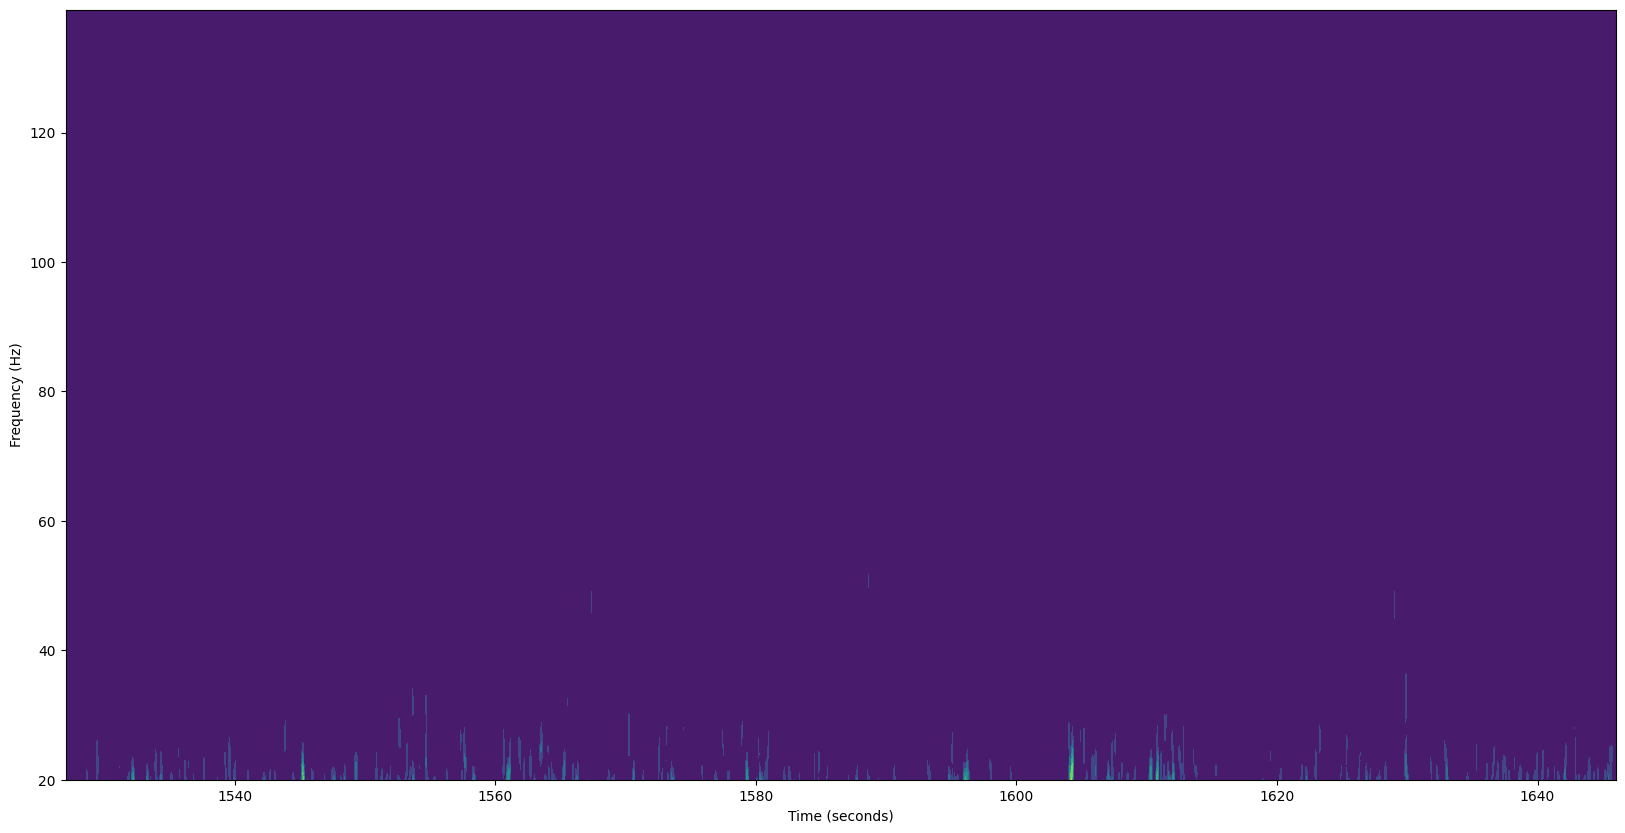

In [47]:
plt.gcf().set_size_inches(20, 10)
plt.contourf(t,np.arange(20,140,1),rem_tf_power[1])
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

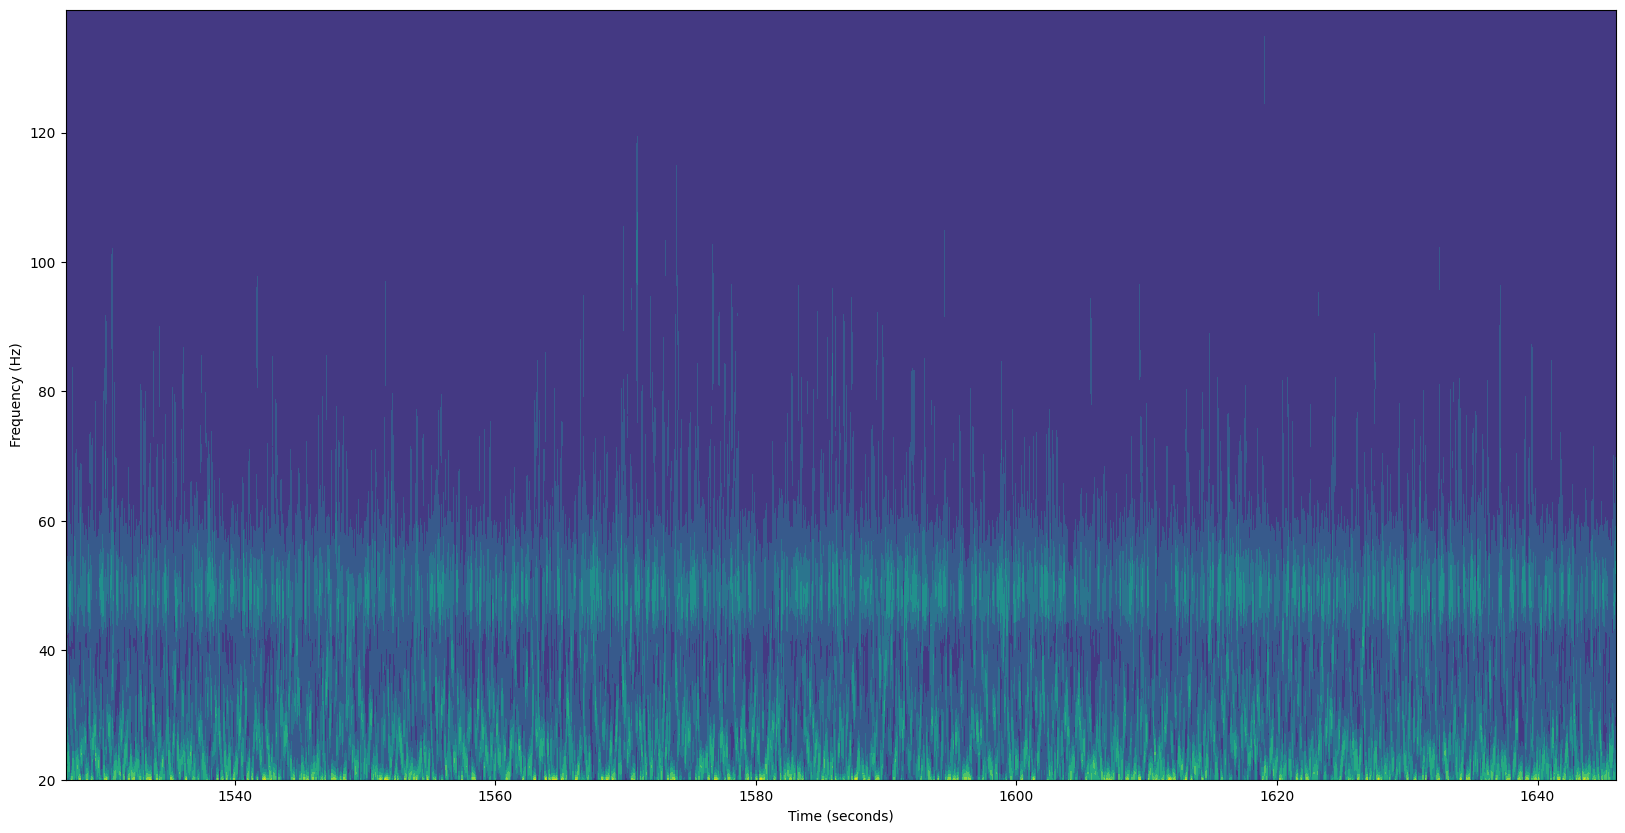

In [53]:
plt.gcf().set_size_inches(20, 10)
plt.contourf(t,np.arange(20,140,1),zscore(rem_tf_power[1],axis=0))
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

In [71]:
rem_two_cycles= rem_dict['REM 2']['Cycles'].astype(int)
rem_two_power= rem_tf_power[1]

print(rem_two_cycles.shape)
print(rem_two_cycles[0:6])


(112, 5)
[[5492953 5493010 5493095 5493218 5493281]
 [5493281 5493362 5493525 5493569 5493604]
 [5493604 5493724 5493878 5493919 5493973]
 [5493973 5494058 5494184 5494225 5494273]
 [5494637 5494656 5494817 5494870 5494937]
 [5494937 5495006 5495074 5495123 5495175]]


In [72]:
new_cycles_var=rem_two_cycles[:,[0,-1]]-rem_periods[1,0]
print(new_cycles_var.shape)
print(new_cycles_var[0:6])



(112, 2)
[[ 453  781]
 [ 781 1104]
 [1104 1473]
 [1473 1773]
 [2137 2437]
 [2437 2675]]


In [73]:
fpp_plots=bin_tf_to_fpp(new_cycles_var,zscore(rem_tf_power[1]),bin_count=19)

Text(0, 0.5, 'Frequency (Hz)')

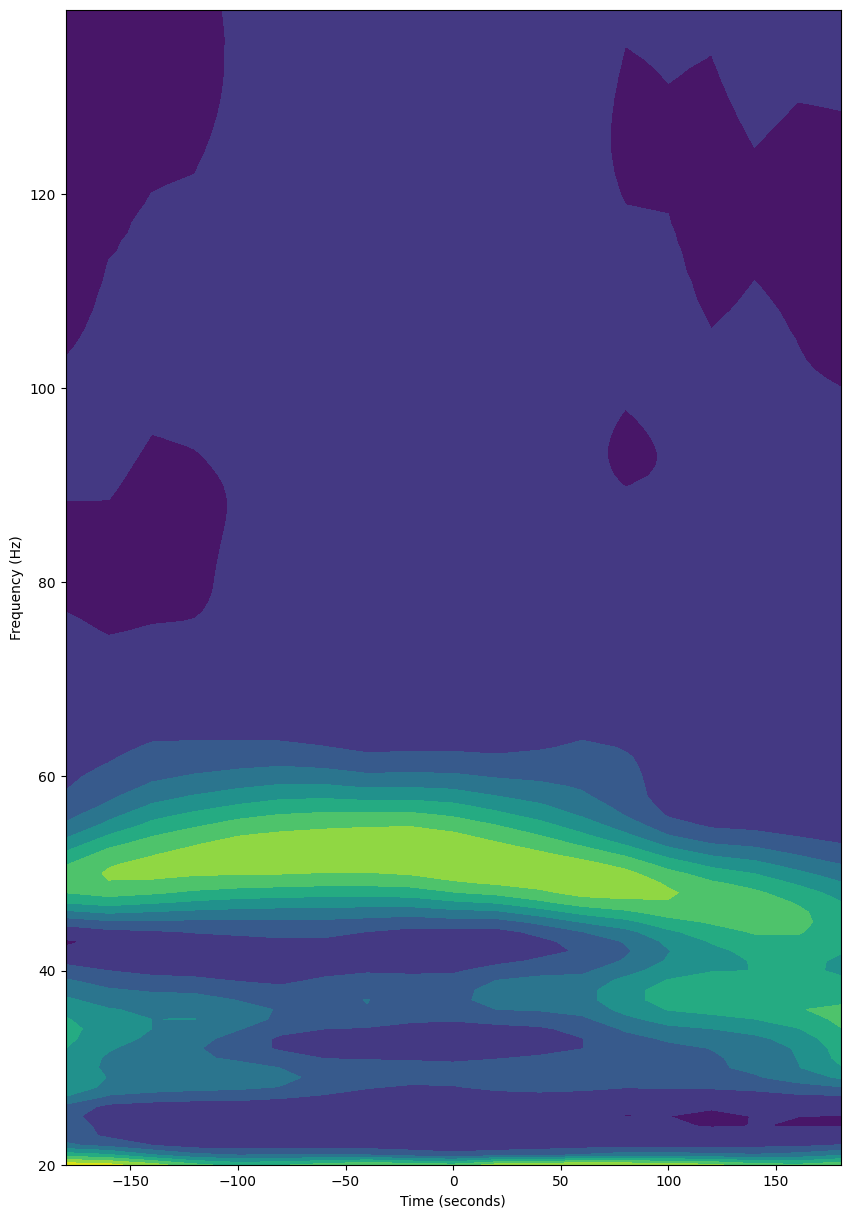

In [74]:
plt.gcf().set_size_inches(10, 15)
plt.contourf(angles,frequencies,fpp_plots[100])
plt.xlabel(r'Phase(°)')
plt.ylabel(r'Frequency (Hz)')